Nosson Weissman <br>
Professor James Topor  <br>
AIM 5001  <br>
March 30, 2021  
# AIM 5001 Final Project
______ 


## Abstract
In this project we investigate how staff duties are assigned at a group home for people with disabilities. We assign difficulty ratings for each duty and use those numbers to quantify employee workload. We also scrape data from Whentowork, an online tool used by the agency for scheduling, to determine hours of experience for a given employee. The main challenge here is converting the data from ink on paper to CSVs and then inserting the CSV data to an actual database. Once we have cleansed and processed previous duty assignment data, the question is relatively straightforward and the answer can be derived with a few SQL queries. Once all of that is done we can get specific numbers to answer our original question. What we find is that we should be shooting for an average employee workload of 13.57 for a given shift.While this number gives a good idea as to the general workload for an average shift, there are two other main questions we should answer before drawing any definite conclusions. 1. Is there/what is the correlation between duty assignments and employee experience. 2. We need to examine data for different shift types, (morning, evening etc.). To do this effectively would require more duty assignment data, but again, once we have the data the numbers shouldn't be too complicated to find.

## Introduction
On weekends I work at a home for people with special needs. At the start of a shift the supervisor assigns duties to each staff member for the shift. This process is tedious and can require upto 30 minutes for a shift. Which brings us to the current project.<br>
The motivation for this project is understanding how to measure a good schedule, and then use this understanding to create an autonomous duty assignment system (which will be used in a backend for a duty assignment webapp). <br>


**Note:**<br>
As this is a group home, laws of HIPPA (Health Insurance Portability and Accountability Act) apply. I have been conscientious throughout this project ensuring that no identifying information for any the residents can be found. Names of residents are in the form of initials, Firstname, or Firstname and initial (ex. Mendy F.). This is legal and within the confines of HIPPA regulation. For more information please check out the [official HIPPA website](https://www.hhs.gov/hipaa/for-individuals/guidance-materials-for-consumers/index.html?language=en)<br>

**Data Being Used:**
Data we are using to answer this question will include staff scheduling info and past staff-resident assignments.<br>

**Staff Scheduling:**<br>
To estimate staff experience, staff scheduling data is scraped from a webapp called WhenToWork, used by the home to track employee schedules. WE Python Scraper Module which has already been implemented thanks to Github user [mneps](https://github.com/mneps/W2W-Data-Project). This step fulfills the requirement the "Project includes at least one Python feature that we did not cover in class” requirement.<br>

**Past Staff-Resident Assignments:**<br>
Past duty assignment data is sourced directly from the group home as non-highlightable PDF documents which are then converted manually to CSV files.
Data is then cleansed and imported to SQL database to allow for simple querying.
<br>

**Loading The Data**<br>
Shift data is loaded from the Postgres database into Pandas dataframes using psycopg2 and pandas. 
WhenToWork data is entered to Pandas dataframes.
<br>

**Determining Fairness**
With difficulty ratings for each task and resident assigned, we analyze the difficulty of each employees assignment for a given shift relative to other assignments on the same shift. Equipt with this data we analyze variance in difficulty of shift assignment in addition to variance and stats on different kinds of assignments.<br>

**Approach**<br>
Data values for each part of the scheduling system are broken down and analyzed, checking not only measures of central tendency (mean, median, mode etc.) but correlation between variables. We use this data to deduce feature importance and the most important factors in creating a fair schedule.

**Data Types**<br>
Due to the nature of scheduling, almost all of the data we're starting with is either text or date data.
This will be mostly categorical ordinal data.
The duty difficulty would be considered numerical discrete. 
_______________
## Project Requirements
- Project includes the use of at least one SQL or NoSQL database system. **Uses SQL database**
- Project includes statistical analysis and graphics that describe and/or validate your data (e.g., EDA). **yes**
- Project includes at least one data reshaping operation. **Cell 78**
- Project includes the use of data-appropriate data preparation and feature engineering methods. **cell41 groupings are considered a type of feature engineering, cell 78 we scale/normalize estimated employee experience**
- Project includes at least one grouping or aggregation. **Cell 22 we use a GROUP BY to get schedule workload for each employee**
- Project includes at least one graphic that supports your conclusion(s). **yes. check cell 48**
- Project includes at least one statistical analysis that supports your conclusion(s). **cells 46, 55**
- Project includes at least one Python feature that we did not cover in class, e.g., something you 
discovered during your coursework or that you found to be necessary for completing your research. **using selenium to interact with website using headless browser and scraping data using scraper**


3) Research Approach (10 Points): Explain + present the end-to-end methodology you made use of for all 
aspects of your Final Project work, including your EDA, data preparation, and investigative analysis 
work. Be sure to include a description of your data management strategy as part of your narrative.

4) Exploratory Data Analysis (25 Points): Explain + present your EDA work including any conclusions you 
draw from your analysis, including any preliminary predictive inferences. This section should include 
any Python code used for the EDA.

5) Data Preparation (15 Points): Describe + show the steps you have taken to address the data integrity + 
usability issues you identified in your EDA, including any feature engineering techniques you have 
applied to the data set. This section should include any Python code used for Data Preparation.

6) Prepped Data Review (5 Points): Explain + present your post-Data Prep EDA analysis. This section 
should include any Python code used for re-running your EDA on the variables adjusted during your 
Data Preparation work.

7) Investigative Analysis & Results (40 Points): Explain + present your investigative analysis work, 
including any Python code used as part of that process. Provide and explain your answers to your 
research questions.

8) Conclusions (10 Points): Summarize your work and clearly state the conclusions of your research. 
Were you able to answer the research questions you originally posed in your Proposal? Comment on 
any potential future extensions of the work you’ve completed for the Project.
Your Jupyter Notebook deliverable should be similar to that of a publication-quality / professional caliber 
document and should include clearly labeled graphics, high-quality formatting, clearly defined section and 
sub-section headers, and be free of spelling and grammar errors. Furthermore, your Pythion code should 
include succinct explanatory comments. 
Upload / submit your Jupyter Notebook within the provided Final Project Canvas submission portal. Be sure to 
save your Notebook using the following nomenclature: first initial_last name_FInalProject" (e.g.,

## The current research question is: What makes a schedule a fair schedule?

In [70]:
import pandas as pd, numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from datetime import date
import re
import csv

_________
## Data Being Used
### Past Staff-Resident Assignments:
<p style="margin: 0, 2rem, 0, 2rem; ">Schedule data will be sourced directly from the group home in the form of paper 
schedules. These paper schedules (written and/or typed) are manually converted to CSV data. (I did intend to the Python Tesseract library, but after seeing the results with a typed schedule, I realized it made sense to just input them manually.</p> <br>

### A paper schudule
<img src='schedule_screenshot.png'>

**This project made use of 100+ pages like this one!**


### Staff Scheduling
We gather staff scheduling data from a webapp called WhenToWork, used by 
the home to track employee schedules. Data will be scraped using the Python Scraper 
Module which has already been implemented thanks to Github user <a href = "https://github.com/mneps">mneps</a>. This step 
shall fulfill the requirement the <em>"Project includes at least one Python feature that we did not 
cover in class”</em> requirement.

### Whentowork schedule format
<img src='w2w_screenshot_censored.jpg'>

**The code used to scrape Whentowork goes through scheduling data month by month and scrapes data from each page.
Data is then extracted to a pandas dataframe using beautifulsoup and sent to a CSV**
<br>

Here is some of the code I used to scrape Whentowork (The complete folder with all the code will be included with project submission): <br>
<img src="scraping_tool_screenshot.png">

## Import scraped whentowork CSV

In [71]:
hours_worked = 'emp_hours_2018-01-01~2020-12-31.csv'
emp_hours_df = pd.read_csv(hours_worked)
csvfile = open(hours_worked, "r")
fnames, lnames = [], []
for row in csv.reader(csvfile):
    #each row has the name of the schedule, sched_type, employee_name, tasks (including residents and houseduties)
    name = row[0]
    hours = row[4]
    #split names on the last space in the name
    staff_name = name.rsplit(' ', 1)
    fname, lname =  '', ''
    if len(staff_name) == 2:
        fname, lname = staff_name
    else:
        fname, lname = staff_name[0], ''
    if fname != 'Employee':
        fnames.append(fname)
        lnames.append(lname)
emp_hours_df= emp_hours_df.drop(columns=['Employee'])
emp_hours_df['Firstname']= fnames
emp_hours_df['Lastname']= lnames
emp_hours_df
cols = emp_hours_df.columns.tolist()
cols.reverse() 
emp_hours_df = emp_hours_df[cols]

### Summary Stats

In [72]:
emp_hours_df.describe()

,Total,2020,2019,2018
count,72.000000,48.000000,53.000000,48.000000
mean,4183.511389,2172.645833,1875.198113,2032.090000
std,17637.931758,7419.232492,6747.999647,6930.300577
min,26.000000,25.500000,14.000000,8.000000
25%,341.687500,331.562500,227.500000,427.375000
50%,1320.710000,845.085000,549.500000,971.875000
75%,3384.750000,1951.625000,1667.250000,1581.312500
max,150606.410000,52143.500000,49692.750000,48770.160000


## Connect with the Postgres database

Here we use the os module to access the database password which is stored as environment variable. <br>
We do this instead of saving the password as plaintext within the project.

In [73]:
import os
password = os.getenv('POSTGRES_PASSWORD')

In [74]:
conn = pg.connect(
    host="localhost",
    port="5433",
    database="shift_info",
    user="postgres",
    password=password,
    sslmode="disable")

def restart_conn():
    conn = pg.connect(
    host="localhost",
    port="5433",
    database="shift_info",
    user="postgres",
    password=password,
    sslmode="disable")
    return conn

## Schematic of the shift_info database being used for the project
<img src="./shift_info_db.jpg">

## Define helper functions for data preperation and SQL inserts

In [75]:
#We use a set of schedules to know if schedule has already been created
#we'll let the user know 
set_of_schedules = set()

def get_schedule_id(schedule_date, shift_type):
    #get rid of white space on shift type and date
    shift_type = shift_type.strip()
    schedule_date = schedule_date.strip()
    schedule_name = schedule_date+shift_type
    #start with the assumption that this is a new schedule
    is_new_schedule = True
    cursor = conn.cursor()
    #check if schedule with this name already exists
    cursor.execute("""SELECT "ScheduleID" FROM schedulenames WHERE "ScheduleName" = '%s';""" % (schedule_name))
    
    #if no such schedule exists, create new scheudule and add to schedule
    if schedule_name not in set_of_schedules and not cursor.rowcount:
        cursor = conn.cursor()
        cursor.execute("""INSERT INTO schedulenames  ("ScheduleName", "ScheduleType", "DateCreated") 
            VALUES('%s', '%s', '%s')""" %(schedule_name, shift_type, schedule_date))
        conn.commit() 
        cursor.close()
        set_of_schedules.add(schedule_name)
    else:
        print('Schedule has already been added. Skipping this schedule')
        is_new_schedule = False
    cursor = conn.cursor()
    cursor.execute("""SELECT "ScheduleID" FROM schedulenames WHERE "ScheduleName" = '%s'; """ % (schedule_name))
    sched_id = cursor.fetchone()[0]
    #return schedule_id and whether scheudle is new or not
    return [sched_id, is_new_schedule]

In [76]:
#function to cleanse staff names

#first we found the most common typos in the CSV and mapped them to their proper names
alt_staff_names = {'Zach P': 'Zachery Perlstein',
                'Sruly A': 'Sruly Appelbaum',
                'Moshe L': 'Moshe Levinson',
                'Joey G': 'Yosef Gerecht',
                'Max G': 'Max Goldstein',
                'Ben W': 'Ben Wexler',
                'Ben wex': 'Ben Wexler',
                'Daniel': 'Daniel Wood',
                'Danirl': 'Daniel Wood',
                'Chaim': 'Chaim Gralla',
                'David': 'David Kuras'
              }
def hacky_fix_for_staff_name(staff_name):
    staff_name = staff_name.strip()
    if staff_name in alt_staff_names:
        staff_name = alt_staff_names[staff_name]
    staff_name = staff_name.rsplit(' ', 1)
    if len(staff_name) == 2:
        fname, lname = staff_name 
    else:
        fname = staff_name[0]
        lname = ''
    return fname, lname

In [77]:
# get employee id for a given name, moving forward this wold be an email address or unique username
def get_emp_id(first_name, last_name=''):
    cursor = conn.cursor()
    cursor.execute("""SELECT "EmpID" FROM employees WHERE "Firstname" = '%s' AND "Lastname" = '%s' ;""" %(first_name, last_name))
    if not cursor.rowcount:
        cursor = conn.cursor()
        cursor.execute("""INSERT INTO employees  ("Firstname", "Lastname") 
            VALUES('%s', '%s')""" % (first_name, last_name))
        conn.commit() 
        cursor.close()
    cursor = conn.cursor()
    cursor.execute("""SELECT "EmpID" FROM employees WHERE "Firstname" = '%s' AND "Lastname" = '%s' ;""" %(first_name, last_name))
    emp_id = cursor.fetchone()[0]
    return emp_id

In [85]:
#get id for a given houseduty
#houseduties include resident assignments (residentassignments ⊆ houseduties )
def get_duty_id(house_duty, shift_type, is_resident=False):
    cursor = conn.cursor()
    cursor.execute("""SELECT "DutyID" FROM houseduties WHERE "DutyName" = '%s' AND "DutyShiftType" = '%s'  AND "IsResident" = '%s'  ;""" 
                                %(house_duty, shift_type, is_resident))
    if not cursor.rowcount:
        cursor = conn.cursor()
        print('adding houseduty: %s for shift: %s'%(house_duty, shift_type))
        duty_id = cursor.execute("""INSERT INTO houseduties  ("DutyName", "DutyDifficulty", "DutyShiftType", "IsResident") 
            VALUES('%s', %d, '%s', '%s');""" % (house_duty, 5, shift_type, is_resident))
        conn.commit() 
        cursor.close()
    cursor = conn.cursor()
    cursor.execute("""SELECT "DutyID" FROM houseduties WHERE "DutyName" = '%s' AND "DutyShiftType" = '%s'  AND "IsResident" = '%s'  ;""" 
                                %(house_duty, shift_type, is_resident))
    duty_id = cursor.fetchone()[0]
    return duty_id

In [79]:
#this just returns the id for a house duty, but is_resident is set to True
def get_partic_id(partic_initials, shift_type):
    return get_duty_id(partic_initials, shift_type, is_resident = True)

In [80]:
def insert_record_to_schedule_table(schedule_id, emp_id, floor_watch, house_duty, fire_duty):
    cursor = conn.cursor()
    duty_id = cursor.execute("""INSERT INTO schedules  ("ScheduleID", "EmpID", "Floorwatch", "HouseDuty", "FireDuty") 
        VALUES(%d, %d, '%s', '%s', '%s');"""% (schedule_id, emp_id, floor_watch, house_duty, fire_duty))
    conn.commit()
    cursor.close()    

In [81]:
#this is where we insert shift assignmnets for a staff member
#a more approriate name could be 'insert_staff_duty_assignment'
def insert_schedule_pairing(schedule_id, emp_id, duty_id, is_resident):
    cursor = conn.cursor()
    cursor.execute("""SELECT "ScheduleID" FROM schedulepairings WHERE "ScheduleID" = %d AND "DutyID" = %d  AND "IsResident" = '%s' """
                                %(schedule_id, duty_id, is_resident))
    if not cursor.rowcount:
        cursor = conn.cursor()
        duty_id = cursor.execute("""INSERT INTO schedulepairings ( "ScheduleID", "EmpID", "ParticID", "DutyID", "IsResident")
            VALUES (%d, %d, %d, %d, %s);""" % (schedule_id, emp_id, duty_id, duty_id, is_resident))
        conn.commit()
        cursor.close()

In [82]:
#to keep track of valid participants
partic_set = set(['NL', 'SI', 'VW', 
                  'MF', 'DF', 'BC', 
                  'MB', 'YE', 'YM', 
                  'YF', 'AE', 'CR', 
                  'ZW','RS'])
#sometimes names are entered instad of initials..
#we want all of our residents stored as initials
#here's our fix
partic_alt_names = {'OF':'DF','MP':'MF',
                    'MR':'MF','MEDY':'MF',
                    'AB':'AE','F':'MF',
                    'SL':'SI','MENDYF': 'MF',
                    'NF':'MF','YN':'YM',
                    'REMY':'RS','RUMY':'RS',
                    'CF':'DF','MENDY F': 'MF', 
                    'MENDY': 'MF'}
#cleanse data from the redidents field
def cleanse_res_field(res_field):
    original_field = res_field
    res_field = res_field.replace('.',',')
    s = res_field
    includes_trainee = False
    
    #usual format when trainee is in schedule
    if s.find('(') and s.find(')'):
        open_paren_index = s.find('(')
        close_paren_index = s.find(')')
        res_field = s[0 : open_paren_index] +' '+ s[close_paren_index:].replace(')','')
        #educated guess that field contains a trainee
        includes_trainee = True
    
    #make initials uppercase in case they had wrong caps
    res_field = res_field.upper()
    res_field = res_field.split(',')
    strings_to_remove = []
    for i in range(len(res_field)):
        res_field[i] = res_field[i].strip()
        el = res_field[i]
        el = el.replace(' ', '')
        if el in partic_alt_names:
            el = partic_alt_names[el]
        if el not in partic_set:
            print('error inserting: ',original_field)
            print('No such resident: ', el,'len:',len(el))
            strings_to_remove.append(el)
        res_field[i] = el
    for s in strings_to_remove:
        res_field.remove(s)
    return res_field, includes_trainee

## Cleanse and insert CSV schedule data to Postgres database

In [83]:
##NOTE: Participant and Resident mean the same thing, they are used interchangably

schedules_filename = 'schedule_records.csv'
csvfile = open(schedules_filename, "r")    
schedule_name_set = set()
schedule_ids = {}
regex_pattern = re.compile(r'[0-9]{4}\-[0-9]{2}\-[0-9]{2}')
for row in csv.reader(csvfile):
    #each row has the name of the schedule, sched_type, employee_name, tasks (including residents and houseduties)
    schedule_date = row[0]
    is_valid_data = len(regex_pattern.findall(schedule_date)) > 0
    #some older data may be included in the CSV but we don't want to include that 
    #so we check here for the date of the schedule
    is_newish_schedule = is_valid_data and  \
            datetime.strptime(schedule_date,'%Y-%m-%d') > datetime.strptime('2019-07-31','%Y-%m-%d')
    #we will use this list to keep track of which
    duties_list = []
    schedule_id = ''
    if is_newish_schedule:
        shift_type = row[1]
        staff_name = row[2]
        staff_name = staff_name.strip()
        #if staff name is empty then go to the next iteration in the loop, to the next row
        if staff_name == '':
            continue
        #participant == resident
        participant_names = row[3] or ''
        #includes_trainee means a staff member was assigned a new staff to train in for the shift
        participant_names, includes_trainee = cleanse_res_field(participant_names)
        duty_dict = {'SK': 'Kitchen',
            'BG': 'Boxes and Garbage',
            'PV': 'Vans',
            'M': 'AMAP',
            '1fl': 'First Floor',
            'K': 'Kitchen',
            'LS': 'Lunches',
            'YB': 'Bookbags',
            '1,2,3': 'First Floor'
        }
        schedule_name = schedule_date+shift_type
        houseduty_names = row[4] or ''
        houseduty_names = houseduty_names.split(',')
        #list comprehension to split up and clean houseduties
        #these are converted to a list
        houseduty_names = [s.strip() for s in houseduty_names]
        #if trainee wasn't already added to houseduties...
        if includes_trainee and 'Trainee' not in houseduty_names:
            #add 'Trainee' as houseduty
            houseduty_names.append('Trainee')
        fire_duty = row[5] or ''
        floor_watch = row[6] or ''
        schedule_id, is_new_schedule = [schedule_ids[schedule_name], is_new_schedule] if schedule_name in schedule_ids \
                        else get_schedule_id(schedule_date, shift_type)
        schedule_ids[schedule_name] = schedule_id
        if is_new_schedule:
            #cleanse staff name
            fname, lname = hacky_fix_for_staff_name(staff_name)
            #get staff id
            emp_id = get_emp_id(fname, lname)
            for i in range(len(houseduty_names)):
                duty = houseduty_names[i]
                duty = duty.strip()
                is_resident = False
                if len(duty) > 0:
                    duty_id = get_duty_id(duty, shift_type)
                    duties_list.append({duty_id:False})
                    insert_schedule_pairing(schedule_id, emp_id, duty_id, is_resident)
                    insert_record_to_schedule_table(schedule_id, emp_id, floor_watch, duty, fire_duty)
            unique_partics = set()
            for i in range(len(participant_names)):
                is_resident = True
                partic = participant_names[i]
                partic = partic.strip()
                if partic not in unique_partics:
                    if len(partic) > 0 and partic in partic_set:
                        partic_id = get_partic_id(partic, shift_type)
                        duties_list.append({partic_id:True})
                        insert_schedule_pairing(schedule_id, emp_id, partic_id, is_resident) #the last parameter, says that this is a resident
                unique_partics.add(partic)
            for duty in duties_list:
                for key, val in duty.items():
                    duty_id = key
                    is_resident = val
                    insert_schedule_pairing(schedule_id, emp_id, duty_id, is_resident)

Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
error inserting:  
No such resident:   len: 0
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
error inserting:  
No such resident:   len: 0
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
error inserting:  
No such resident:   len: 0
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
error inserting:  
No such resident:   len: 0
Schedule has already been added. Skipping this schedule
Schedule has already been added. Skipping this schedule
error inserting:  
No such resident:   len: 0
Schedule has already been added. Skipping 

## Confirm that scedules have been inserted

In [111]:
#select statemnt to get all recently inserted schedules
complete_schedules = pd.read_sql_query("""SELECT * FROM schedulenames sn
                        INNER JOIN (SELECT DISTINCT "DutyID", "ScheduleID", "EmpID", "IsResident" FROM schedulepairings) sp
                        ON sn."ScheduleID" = sp."ScheduleID"
                        INNER JOIN (SELECT DISTINCT "ScheduleID", "EmpID", "Floorwatch", "FireDuty" FROM schedules) s
                        ON s."EmpID" = sp."EmpID" AND s."ScheduleID" = sp."ScheduleID"
                        INNER JOIN employees e
                        ON e."EmpID" = sp."EmpID"
                        INNER JOIN houseduties hd
                        ON hd."DutyID" = sp."DutyID"
                        WHERE s."ScheduleID" > 410
                        ORDER BY sp."ScheduleID" DESC, e."Firstname" DESC;""", conn)
#remove duplicate columns
complete_schedules = complete_schedules.loc[:,~complete_schedules.columns.duplicated()]
#drop unneeded columns
cols_to_drop = ['TeamLeaderEmpID', 'PostArr', 
                 'HtmlOfCurrSchedule','IsSupervisor', 
                 'IsAdmin', 'CertificationRequired'
                ]

complete_schedules = complete_schedules.drop(columns = cols_to_drop)

In [116]:
#these are all the schedules recently inserted
display(complete_schedules)

,ScheduleID,ScheduleName,ScheduleType,DateCreated,DutyID,EmpID,IsResident,Floorwatch,FireDuty,Firstname,Lastname,DateOfHire,DateOfCurrentScipCert,DateOfCurrentCprCert,DateOfCurrentAmapCert,DateOfTermination,DutyName,DutyDifficulty,DutyShiftType
0,1304,2020-12-19SHAB_PM,SHAB_PM,2020-12-19,273,7,False,,FB,Zach,Shulman,2018-04-15,2020-08-03,2020-08-16,1975-01-01,None,AMAP,5,SHAB_PM
1,1304,2020-12-19SHAB_PM,SHAB_PM,2020-12-19,353,7,True,,FB,Zach,Shulman,2018-04-15,2020-08-03,2020-08-16,1975-01-01,None,YM,4,SHAB_PM
2,1304,2020-12-19SHAB_PM,SHAB_PM,2020-12-19,330,8,True,,3,Yosef,Gerecht,2018-04-20,2020-08-03,2020-08-03,1975-01-01,None,DF,7,SHAB_PM
3,1304,2020-12-19SHAB_PM,SHAB_PM,2020-12-19,327,8,True,,3,Yosef,Gerecht,2018-04-20,2020-08-03,2020-08-03,1975-01-01,None,BC,2,SHAB_PM
4,1304,2020-12-19SHAB_PM,SHAB_PM,2020-12-19,286,8,False,,3,Yosef,Gerecht,2018-04-20,2020-08-03,2020-08-03,1975-01-01,None,Restocking,5,SHAB_PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,1143,2019-12-06FRI_PM,FRI_PM,2019-12-06,375,1,False,,2,Nosson,Weissman,2016-03-20,2019-06-10,2020-04-06,2020-08-04,None,Elevator clean up,5,FRI_PM
3048,1143,2019-12-06FRI_PM,FRI_PM,2019-12-06,374,1,False,,2,Nosson,Weissman,2016-03-20,2019-06-10,2020-04-06,2020-08-04,None,1st floor,5,FRI_PM
3049,1143,2019-12-06FRI_PM,FRI_PM,2019-12-06,355,9,True,2e,MA,Nesanel,First,2019-10-10,2020-08-04,2020-08-02,1975-01-01,None,VW,5,FRI_PM
3050,1143,2019-12-06FRI_PM,FRI_PM,2019-12-06,343,9,True,2e,MA,Nesanel,First,2019-10-10,2020-08-04,2020-08-02,1975-01-01,None,MB,5,FRI_PM


In [117]:
#calculate how long each emplyee has been working at time of schedule creation
total_experience_when_schedule_was_created = complete_schedules.DateCreated - complete_schedules.DateOfHire
#add this to scheduling for reference
complete_schedules['CurrentExperience'] = total_experience_when_schedule_was_created

In [118]:
complete_schedules.describe()

,ScheduleID,DutyID,EmpID,DutyDifficulty,CurrentExperience
count,3052.000000,3052.000000,3052.000000,3052.000000,3045
mean,1223.756225,331.333879,27.923984,4.955439,902 days 17:36:28.374384240
std,47.204273,39.976168,33.166200,1.564304,735 days 03:50:19.796907080
min,1143.000000,233.000000,1.000000,0.000000,12 days 00:00:00
25%,1183.000000,309.000000,4.000000,4.000000,473 days 00:00:00
50%,1225.000000,326.000000,8.000000,5.000000,719 days 00:00:00
75%,1264.000000,349.000000,53.000000,5.000000,1356 days 00:00:00
max,1304.000000,454.000000,105.000000,8.000000,5527 days 00:00:00


## Explore employee info

In [135]:
#get employee info for employees in recently added schedules
def get_info_for_emps_on_specific_shifts(schedule_ids):
    sched_id_list = set(val for key, val in schedule_ids.items())
    sched_id_list = list(sched_id_list)
    #convert list to a string which can be used in a sql query
    sched_ids = re.sub(r'\[*]*', '', str(sched_id_list))
    emp_ids = pd.read_sql_query("""SELECT DISTINCT "EmpID" 
        FROM schedules 
        WHERE "ScheduleID" IN (%s)""" % (sched_ids), conn)
    cursor = conn.cursor()
    cursor.execute("""SELECT DISTINCT "EmpID" 
        FROM schedules 
        WHERE "ScheduleID" IN (%s)""" % (sched_ids))
    emp_ids = [r[0] for r in cursor.fetchall()]
    emp_ids_string = re.sub(r'\[*]*', '', str(emp_ids))
    emps_on_shift_df = pd.read_sql_query("""SELECT *
        FROM employees 
        WHERE "EmpID" IN (%s)""" % (emp_ids_string), conn)
    return emps_on_shift_df

In [136]:
#scheudleids contains ids for schedules we just processed
emps_df = get_info_for_emps_on_specific_shifts(schedule_ids)
emps_df = emps_df.drop(columns=['IsSupervisor', 'IsAdmin',
                                'DateOfCurrentCprCert', 'DateOfCurrentScipCert', 
                                'DateOfCurrentAmapCert', 'DateOfTermination'
                               ])
emps_df

,EmpID,Firstname,Lastname,DateOfHire
0,1,Nosson,Weissman,2016-03-20
1,9,Nesanel,First,2019-10-10
2,10,Yaakov,Abeaziz,2013-05-14
3,11,Chaim,Gralla,2019-10-10
4,15,Mark,Gersten,2019-10-10
5,16,Aubrey,Denny,2019-10-10
6,17,Karina,Solage,2019-10-10
7,18,James,Kemp,2019-10-10
8,2,Pinhas,Adout,2018-04-15
9,21,Meir,Werther,2019-10-10


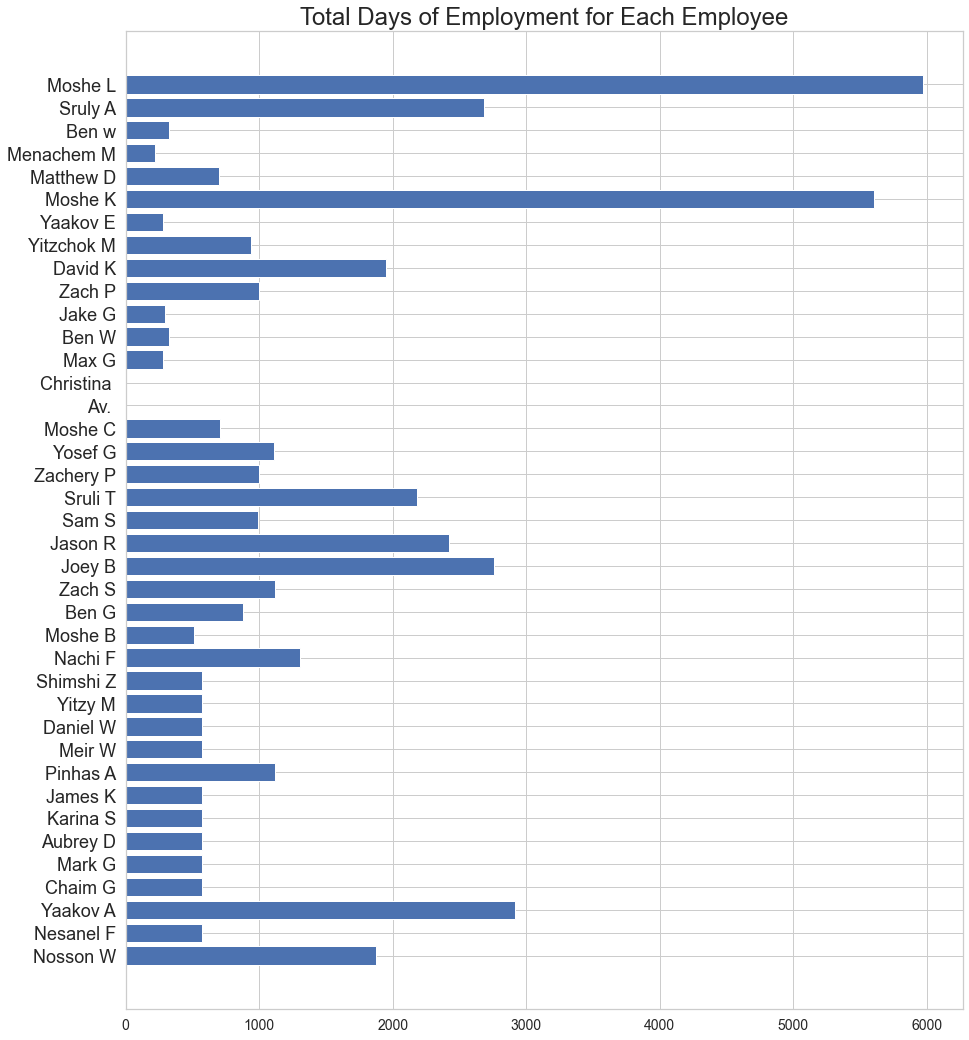

In [137]:
# emps_df.DateOfHire = emps_df.DateOfHire.fillna(datetime.strptime('2020-06-30', '%Y-%m-%d').date())
#we don't have hiring date for all employees, so we will fill na with today's date
emps_df.DateOfHire = emps_df.DateOfHire.fillna(date.today())
days_since_hire_col = date.today() - emps_df.DateOfHire
# days_since_hire_col = days_since_hire_col.fillna(30)
emps_df['DaysSinceHire'] = pd.to_numeric(days_since_hire_col.dt.days)
plt.figure(figsize=(15,18))
plt.barh(emps_df.Firstname+' '+emps_df['Lastname'].astype(str).str[0].fillna(''), emps_df.DaysSinceHire)
plt.title('Total Days of Employment for Each Employee', size='24')
plt.xticks(size=14)
plt.yticks(size=18)
plt.show()
# plt.figure(figsize=(10,10))

In [138]:
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10,10))
# emps_df["Name"] = emps_df["Firstname"]+" "+emps_df["Lastname"]
# plt.title('Total Days of Employment for Each Employee', size='24')
# ax = sns.barplot(x="DaysSinceHire", y="Name" , data=emps_df)
# emps_df.DaysSinceHire.describe()
emps_df.drop(columns=['EmpID']).describe()

,DaysSinceHire
count,40.000000
mean,1248.650000
std,1326.615504
min,0.000000
25%,574.000000
50%,702.000000
75%,1446.250000
max,5969.000000


## Explore houseduties 
Populated before project

In [139]:
houseduties = pd.read_sql_query("""SELECT * FROM houseduties""", conn)
houseduties

,DutyID,DutyName,DutyDifficulty,DutyShiftType,IsResident,CertificationRequired
0,233,CR,5,SHAB_AM,True,None
1,234,Kitchen,6,PM,False,False
2,235,Bookbags,4,PM,False,False
3,236,Restocking,4,Shabbos,False,False
4,237,* TRIAL *,2,PM,False,False
...,...,...,...,...,...,...
208,450,Living room Basement,5,SHAB_PM,False,False
209,451,1st fl,5,SHAB_PM,False,False
210,452,eLevator,5,SHAB_PM,False,False
211,453,Trainee,5,FRI_PM,False,False


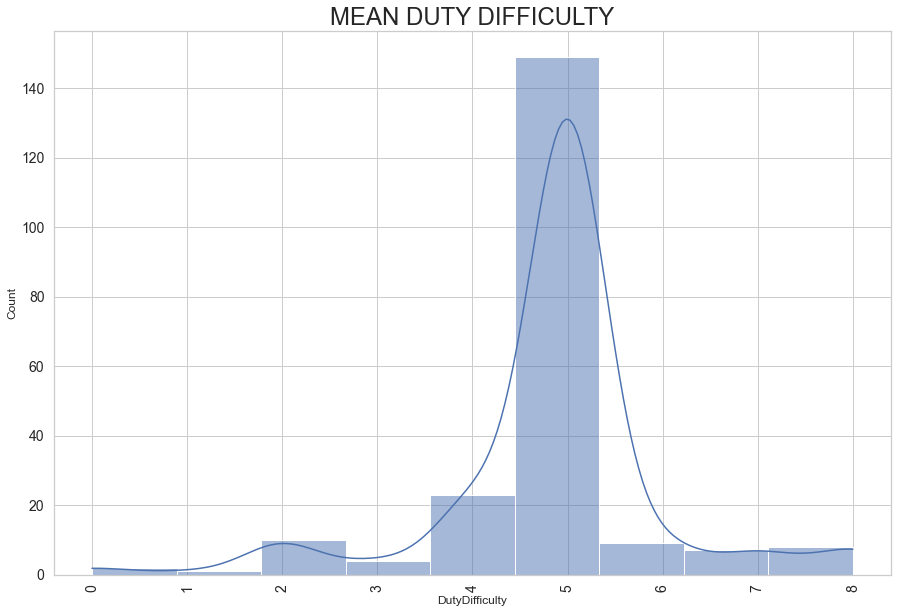

In [144]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))
# plt.bar(emps_df.Lastname, avg_workload.tolist())
sns.histplot(data=houseduties.DutyDifficulty, kde=True)
plt.title('MEAN DUTY DIFFICULTY', size='24')
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)
plt.show()

## Analyze shift / employee workloads

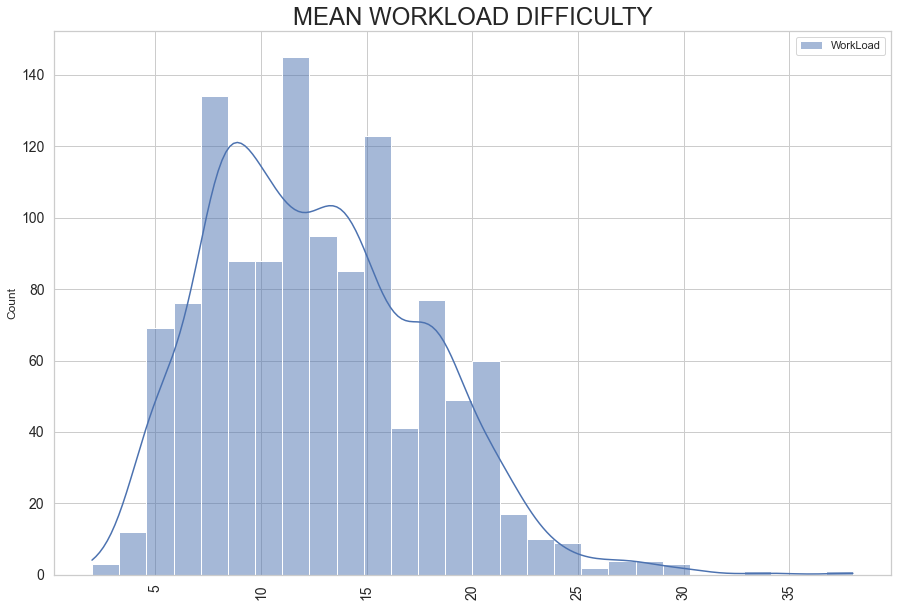

In [141]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))
# plt.bar(emps_df.Lastname, avg_workload.tolist())
sns.histplot(data=workloads, kde=True)
plt.title('MEAN WORKLOAD DIFFICULTY', size='24')
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)
plt.show()

In [ ]:
shift_load_by_schedules = pd.DataFrame(complete_schedules.groupby(['ScheduleName','Firstname', 'Lastname'])['DutyDifficulty'].agg('sum'))

In [84]:
display(shift_load_by_schedules)

DutyDifficulty
ScheduleName      Firstname Lastname                 
2019-12-06FRI_PM  Nesanel   First                  16
                  Nosson    Weissman               22
                  Pinhas    Adout                  13
                  Sruly     Appelbaum              21
                  Yaakov    Abeaziz                11
...                                               ...
2020-12-19SHAB_PM Moshe     Brum                   20
                  Pinhas    Adout                  14
                  Yaakov    Eiferman               19
                  Yosef     Gerecht                19
                  Zach      Shulman                 9

[1196 rows x 1 columns]

In [40]:
complete_schedules.CurrentExperience.describe()

count                           3045
mean     902 days 17:36:28.374384240
std      735 days 03:50:19.796907080
min                 12 days 00:00:00
25%                473 days 00:00:00
50%                719 days 00:00:00
75%               1356 days 00:00:00
max               5527 days 00:00:00
Name: CurrentExperience, dtype: object

In [52]:
houseduties2 = houseduties
backup = houseduties

In [ ]:
workloads = pd.read_sql_query("""SELECT  scheds."Firstname",scheds."Lastname",scheds."ScheduleName", SUM(scheds."DutyDifficulty") AS "WorkLoad" FROM (SELECT e."Firstname",e."Lastname", e."EmpID", sn."DateCreated", sn."ScheduleName", hd."DutyDifficulty" FROM schedulenames sn
                    INNER JOIN (SELECT DISTINCT "DutyID", "ScheduleID", "EmpID", "IsResident" FROM schedulepairings) sp
                    ON sn."ScheduleID" = sp."ScheduleID"
                    INNER JOIN (SELECT DISTINCT "ScheduleID", "EmpID", "Floorwatch", "FireDuty" FROM schedules) s
                    ON s."EmpID" = sp."EmpID" AND s."ScheduleID" = sp."ScheduleID"
                    INNER JOIN employees e
                    ON e."EmpID" = sp."EmpID"
                    INNER JOIN houseduties hd
                    ON hd."DutyID" = sp."DutyID"
                    WHERE s."ScheduleID" > 410
                    ORDER BY sp."ScheduleID" DESC, e."Firstname" DESC) AS scheds
                    GROUP BY (scheds."Firstname",scheds."Lastname",scheds."ScheduleName")""", conn)

### The dataframe below shows total workload for an employee on each given shift. This is the sum of all assigned task difficulties for a shift.

In [161]:
workloads.describe()

,Firstname,Lastname,ScheduleName,WorkLoad,Name
0,Aubrey,Denny,2020-02-11FRI_PM,13,Aubrey D
1,Aubrey,Denny,2020-02-12FRI_PM,34,Aubrey D
2,Aubrey,Denny,2020-02-18FRI_PM,16,Aubrey D
3,Aubrey,Denny,2020-02-19FRI_PM,22,Aubrey D
4,Av.,,2020-02-16FRI_PM,19,NaN
...,...,...,...,...,...
1191,Zachery,Perlstein,2020-11-28SHAB_PM,14,Zachery P
1192,Zachery,Perlstein,2020-12-04FRI_PM,17,Zachery P
1193,Zachery,Perlstein,2020-12-05SHAB_AM,10,Zachery P
1194,Zachery,Perlstein,2020-12-05SHAB_PM,28,Zachery P


In [163]:
workloads.describe()

,WorkLoad
count,1196.000000
mean,12.645485
std,5.072832
min,2.000000
25%,9.000000
50%,12.000000
75%,16.000000
max,38.000000


In [160]:
#groupby to get average workload for each schedule
workloads_by_schedule = pd.read_sql_query("""SELECT "ScheduleType","ScheduleName", AVG("WorkLoad") AS "WorkLoad" 
                        FROM (SELECT scheds."ScheduleType", scheds."Firstname",scheds."Lastname",scheds."ScheduleName", SUM(scheds."DutyDifficulty") AS "WorkLoad" 
                        FROM (SELECT sn."ScheduleType", e."Firstname",e."Lastname", e."EmpID", sn."DateCreated", sn."ScheduleName", hd."DutyDifficulty" 
                        FROM schedulenames sn
                        INNER JOIN (SELECT DISTINCT "DutyID", "ScheduleID", "EmpID", "IsResident" FROM schedulepairings) sp
                        ON sn."ScheduleID" = sp."ScheduleID"
                        INNER JOIN (SELECT DISTINCT "ScheduleID", "EmpID", "Floorwatch", "FireDuty" FROM schedules) s
                        ON s."EmpID" = sp."EmpID" AND s."ScheduleID" = sp."ScheduleID"
                        INNER JOIN employees e
                        ON e."EmpID" = sp."EmpID"
                        INNER JOIN houseduties hd
                        ON hd."DutyID" = sp."DutyID"
                        WHERE s."ScheduleID" > 410
                        ORDER BY sp."ScheduleID" DESC, e."Firstname" DESC) AS scheds
                        GROUP BY (scheds."Firstname",scheds."ScheduleType",scheds."Lastname",scheds."ScheduleName")) as workloads
                        GROUP BY ("ScheduleType","ScheduleName"); """, conn)
# workloadsb
# workloads.sql('''SELECT Firstname,	Lastname,	ScheduleName, sum(WorkLoad) GROUP BY Firstname,	Lastname,	ScheduleName,''')

### The dataframe below shows the mean workload for each schedule. This was calculated using nested aggregate statements

In [162]:
workloads_by_schedule

,ScheduleType,ScheduleName,WorkLoad
0,FRI_PM,2019-12-06FRI_PM,16.857143
1,FRI_PM,2019-12-13FRI_PM,15.000000
2,FRI_PM,2019-12-20FRI_PM,15.375000
3,FRI_PM,2019-12-27FRI_PM,16.857143
4,FRI_PM,2020-01-03FRI_PM,12.500000
...,...,...,...
157,SHAB_PM,2020-11-28SHAB_PM,15.000000
158,SHAB_PM,2020-12-05SHAB_PM,15.250000
159,SHAB_PM,2020-12-12SHAB_PM,11.000000
160,SHAB_PM,2020-12-15SHAB_PM,14.571429


In [56]:
workloads_by_schedule.describe()

,WorkLoad
count,162.000000
mean,12.690971
std,3.014843
min,7.000000
25%,8.750000
50%,14.000000
75%,14.875000
max,20.833333


**Comparing the median (50%) of the previous two dataframes, we can see than there's a two point difference depending on how we calculate the average**

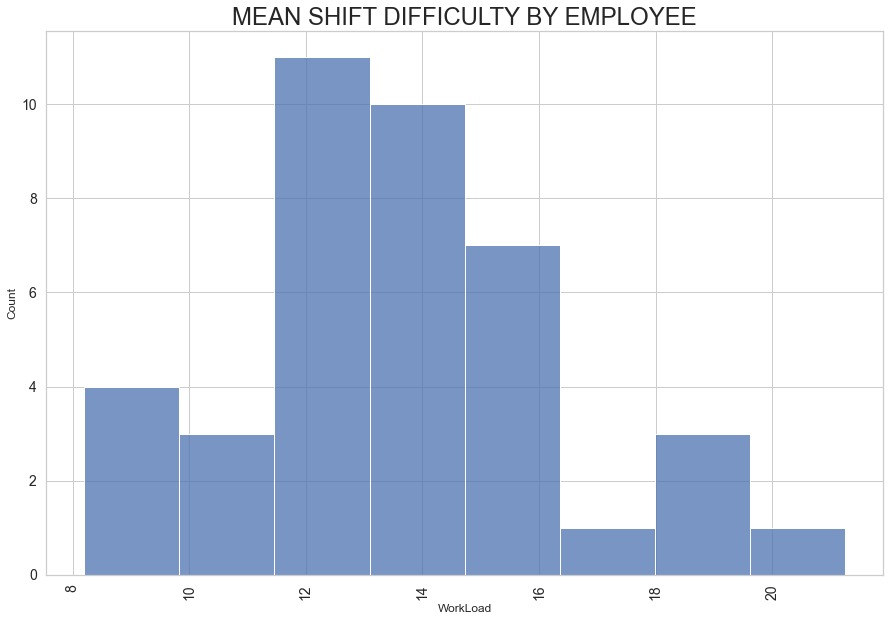

In [58]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))
# plt.bar(emps_df.Lastname, avg_workload.tolist())
sns.histplot(data=avg_workload)
plt.title('MEAN SHIFT DIFFICULTY BY EMPLOYEE', size='24')
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)
plt.show()

In [150]:
avg_workload.describe()

count    40.000000
mean     13.565035
std       2.832571
min       8.200000
25%      12.137500
50%      13.463900
75%      15.050000
max      21.250000
Name: WorkLoad, dtype: float64

In [65]:
emps_df['AverageShiftDifficulty'] = avg_workload.tolist()
emps_df.corr()

,EmpID,AverageShiftDifficulty
EmpID,1.000000,-0.310442
AverageShiftDifficulty,-0.310442,1.000000


### Below is the mean difficulty shift for each employee.


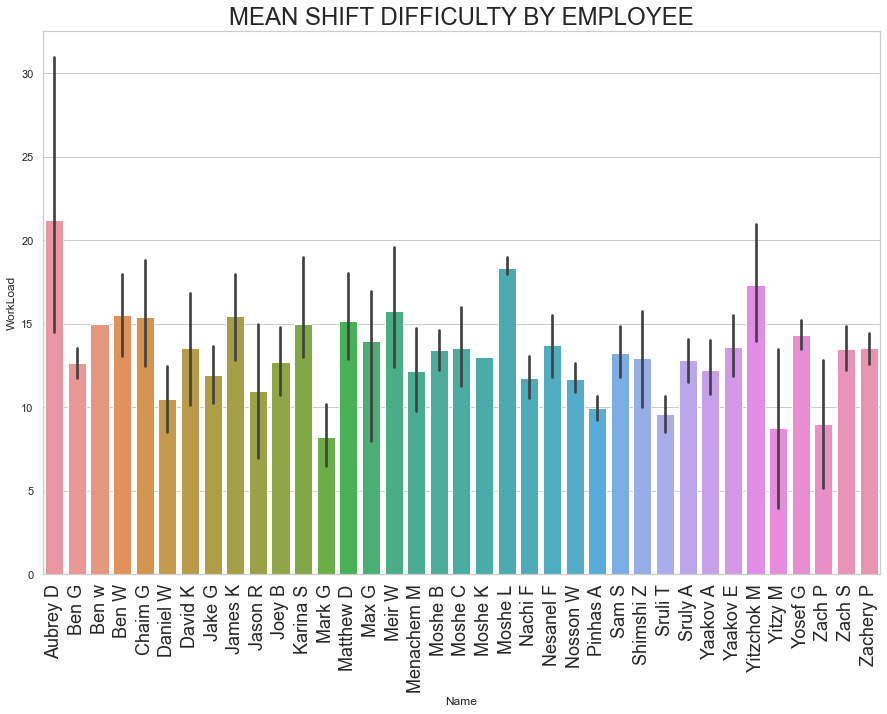

In [156]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90, size=14)
plt.title('MEAN SHIFT DIFFICULTY BY EMPLOYEE', size='24')
workloads["Name"] = workloads["Firstname"]+" "+workloads["Lastname"].astype(str).str[0]
plt.xticks(size=18)
ax = sns.barplot(x="Name", y="WorkLoad", data=workloads)
plt.show()

In [ ]:
### Looking at the above graph, we can see that some employees have much easier shift on average. 
### There are more than a couple of factors causing this result. But a couple of reasons are some eomplyees work mainly on shifts which inolve fewer duty assignments. Such is that case with Am shifts, and SHAB_AM shift. 
### A second reason for the seeming imbalance is that supervisors tend to have lighter workloads. 
### Being that supervising is not accounted for in this model, it seems like they have easier shifts.

In [158]:
avg_workload = workloads.groupby(['Firstname',	'Lastname'])['WorkLoad'].agg('mean')
pd.DataFrame(avg_workload)

WorkLoad
Firstname Lastname              
Aubrey    Denny        21.250000
Av.                    19.000000
Ben       Gil          12.687500
          Wexler       15.538462
          w            15.000000
Chaim     Gralla       15.416667
Christina              19.000000
Daniel    Wood         10.500000
David     Kuras        13.571429
Jake      Goldson      11.950000
James     Kemp         15.500000
Jason     Rutman       11.000000
Joey      Bouskila     12.818182
          Bouskilla    12.555556
Karina    Solage       15.000000
Mark      Gersten       8.200000
Matthew   Davis        15.200000
Max       Goldstein    14.000000
Meir      Werther      15.800000
Menachem  Muller       12.200000
Moshe     Brum         13.414286
          Cohen        13.545455
          Kieval       13.000000
          Levinson     18.333333
Nachi     Frankel      11.777778
Nesanel   First        13.714286
Nosson    Weissman     11.729323
Pinhas    Adout         9.965812
Sam       Shmaya       13.230769
Shimshi   Zellermaier  12.937500
Sruli     Teitelbaum    9.583333
Sruly     Appelbaum    12.822581
Yaakov    Abeaziz      12.235294
          Eiferman     13.600000
Yitzchok  Moshiyakov   17.333333
Yitzy     Muller        8.750000
Yosef     Gerecht      14.360656
Zach      Perlstein     9.000000
          Shulman      13.513514
Zachery   Perlstein    13.566372

## Below we find a distribution which is multimodal<br>

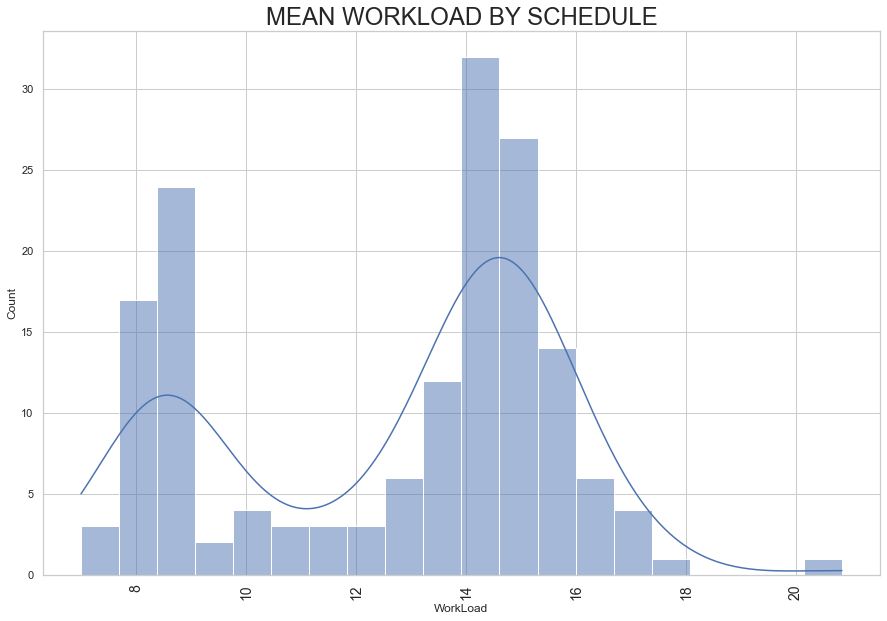

In [100]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90, size=14)
plt.title('MEAN WORKLOAD BY SCHEDULE', size='24')
# ax = sns.barplot(x="ScheduleName", y="WorkLoad", data=workloads)
sns.histplot(data=workloads_by_schedule, x='WorkLoad', bins=20, kde=True)
plt.show()


### Once we break down the workload by scheduletype, things become clear:

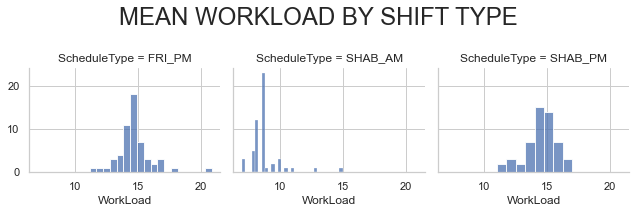

In [146]:
g = sns.FacetGrid(workloads_by_schedule, col="ScheduleType")
g.map(sns.histplot, "WorkLoad")
plt.suptitle('MEAN WORKLOAD BY SHIFT TYPE', size='24')
g.fig.subplots_adjust(top=0.7) 
plt.show()

### ...different shifts have different mean duty difficulties

In [43]:
avg_duty_difficulty_by_shift_type = pd.read_sql_query("""SELECT "DutyShiftType", AVG("DutyDifficulty") AS "MeanShiftDifficulty" FROM houseduties GROUP BY "DutyShiftType"; """, conn)
avg_duty_difficulty_by_shift_type

,DutyShiftType,MeanShiftDifficulty
0,FRI_PM,4.753247
1,Shabbos,4.000000
2,SHAB_AM,5.100000
3,SHAB_PM,4.953488
4,AM,4.250000
5,PM,5.000000


## Normalized estimated-employee-experience made wide

In [149]:
emps_df['EstimatedExp'] = (emps_df.DaysSinceHire-np.min(emps_df.DaysSinceHire))/(np.max(emps_df.DaysSinceHire)-np.min(emps_df.DaysSinceHire))
pd.DataFrame([emps_df.Lastname, emps_df.EstimatedExp]).drop(columns=[1])

,0,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
Lastname,Weissman,Abeaziz,Gralla,Gersten,Denny,Solage,Kemp,Adout,Werther,Wood,...,Kuras,Bouskilla,Moshiyakov,Eiferman,Kieval,Davis,Muller,w,Appelbaum,Levinson
EstimatedExp,0.313788,0.488189,0.096164,0.096164,0.096164,0.096164,0.096164,0.187134,0.096164,0.096164,...,0.326855,0.462389,0.157313,0.046574,0.938851,0.117105,0.036354,0.054448,0.449154,1.0


## Conclusion
_____
Looking at the median workoad for each one of the shifts by employee or by median shift workload by shift type, our number ranges between 12 and 14. But as we've seen, workload also varies by shift type and staff member. For now our conlusion is that more research must be done to come up with a real solution.